# Image data sets

In [1]:
%matplotlib inline

import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
import corner
import logging

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.INFO,
)


## Options

In [2]:
highres = False
transform = False


## Transform images to numpy arrays (only need to do this once)

In [3]:
if transform:
    np.save(
        "../data/samples/gan2d/x_grid.npy",
        np.array([plt.imread(f"../data/samples/gan2d/grid/grid_64_{i:04}.png") for i in range(81)])
    )
    np.save(
        "../data/samples/gan2d/x_highres_grid.npy",
        np.array([plt.imread(f"../data/samples/gan2d/grid/grid_1024_{i:04}.png") for i in range(81)])
    )
    np.save(
        "../data/samples/gan2d/x_train.npy",
        np.array([plt.imread(f"../data/samples/gan2d/grid/subspace_64_{i:05}.png") for i in range(10000)])
    )
    np.save(
        "../data/samples/gan2d/x_test.npy",
        np.array([plt.imread(f"../data/samples/gan2d/grid/subspace_64_{i:05}.png") for i in range(10000, 11000)])
    )


## Get data

In [4]:
boundary = 2.0
resolution = 9
each = np.linspace(-boundary, boundary, resolution)
each_grid = np.meshgrid(*[each for _ in range(2)], indexing="ij")
each_grid = [x.flatten() for x in each_grid]
gan_zs = np.vstack(each_grid).T

In [5]:
gan_images = np.load("../data/samples/gan2d/x_{}grid.npy".format("highres_" if highres else ""))

## Plot data

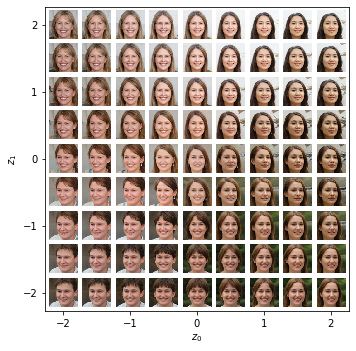

In [6]:
size = 0.42
fig = plt.figure(figsize=(5,5))

for z, image in zip(gan_zs, gan_images):
    # imagebox = OffsetImage(image, zoom=zoom)
    # ab = AnnotationBbox(imagebox, z)
    
    plt.imshow(image, extent=(z[0]-size/2, z[0]+size/2, z[1]-size/2, z[1]+size/2))

plt.ylabel("$z_1$")
plt.xlabel("$z_0$")
plt.xlim(-2 - 1.3*size/2, 2 + 1.3*size/2)
plt.ylim(-2 - 1.3*size/2, 2 + 1.3*size/2)

plt.tight_layout()
plt.savefig("../figures/gan2d_grid.pdf", dpi=600)
    